In [102]:
import pandas as pd
import numpy as np
import statistics as stat
import seaborn as sns
import matplotlib.pyplot as plt
import random
import re

In [131]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Preprocessing function for transcripts
def preprocess_text(text):
    if text is None:  # Check if the text is None
        return ""  # Return an empty string if text is None
    text = text.lower()  # Convert text to lowercase
    text = re.sub(r'[,]', '', text)
    # Tokenization
    words = text.split()
    # Removing Stop Words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # Stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    return ' '.join(words)  # Return the processed text as a single string

In [ ]:
# # Separate interview into sentences
# def process_transcript(text):
#     sentences = re.split(r'(?<=\|)', text)
#     cleaned_sentences = [
#         re.sub(r'^(interviewer:|interviewee:)\s*', '', s.strip().replace('|', '')) for s in sentences if s.strip()
#     ]
#     return cleaned_sentences

# merged_df['Processed Transcript'] = merged_df['transcript'].apply(process_transcript)

In [132]:
import pandas as pd

# Step 1: Load the Transcripts
scores_file = "data/scores.csv"  # target
scores_df = pd.read_csv(scores_file)

transcripts_file = 'data/transcripts.csv'  # Replace with your transcripts file path
transcripts_df = pd.read_csv(transcripts_file, header=None)


# Step 2: Initialize a list to hold structured data
structured_data = []

# Step 3: Process each row in the DataFrame
for index, row in transcripts_df.iterrows():
    # participant_id = row[0]  # Extract participant ID from the first column using iloc
    # transcript = row[1]  # Get the transcript from the second column using iloc
    participant_id = row[0]
    transcript = row[1]
    parts = transcript.split('|')  # Split the transcript based on '|'
    
    # Initialize variables to hold questions and answers
    current_question = ""
    current_answer = ""
    question_number = 0  # Initialize question number for the participant
    
    # Step 4: Iterate through the parts and extract questions and answers
    for part in parts:
        part = part.strip()  # Remove leading/trailing whitespace
        if part.startswith("Interviewer:"):
            # If there's an ongoing answer, save it before starting a new question
            if current_answer:
                structured_data.append({
                    'Participant': participant_id,  # Create unique question ID
                    'participant&question': f"{participant_id}q{question_number}",  # Create unique question ID
                    'question': current_question,
                    'answer': current_answer.strip()
                })
                current_answer = ""  # Reset current answer
            # Set the current question and increment question number
            current_question = part.replace("Interviewer:", "").strip()
            question_number += 1  # Increment question number
        elif part.startswith("Interviewee:"):
            # Append the answer
            current_answer += part.replace("Interviewee:", "").strip() + " "
    
    # After the loop, check if there's an ongoing answer to save
    if current_question and current_answer:
        structured_data.append({
            'Participant': participant_id,  # Create unique question ID
            'participant&question': f"{participant_id}q{question_number}",  # Create unique question ID
            'question': current_question,
            'answer': current_answer.strip()
        })

# Step 5: Create a DataFrame from the structured data
structured_df = pd.DataFrame(structured_data)

# Step 6: Display the structured DataFrame
print("Structured DataFrame:")
print(structured_df.head())
# Apply preprocessing to the transcript data; # we use cleaning the stop words and stemmer for improving the textual data
structured_df['processed_questions'] = structured_df['question'].apply(preprocess_text)
structured_df['processed_answers'] = structured_df['answer'].apply(preprocess_text)
# Create the merged df for directly for later use
merged_df = structured_df.merge(scores_df[['Participant', 'Overall', 'Excited']], on='Participant', how='left')
# Save to a new CSV file
merged_df.to_csv('data/clean_transcripts.csv', index=False)  
print(merged_df.head())
# Step 7: Save the Structured Data to a CSV file
# structured_df.to_csv('data/clean_transcripts.csv', index=False)  # Save to a new CSV file

Structured DataFrame:
  Participant participant&question  \
0          p1                 p1q1   
1          p1                 p1q2   
2          p1                 p1q3   
3          p1                 p1q4   
4          p1                 p1q5   

                                            question  \
0                              So how are you doing?   
1         Ok well  so please tell me about yourself.   
2                                              mhhmm   
3  So please tell me about a time that you demons...   
4  Tell me about a time when your working on a te...   

                                              answer  
0                                    Im pretty good.  
1  ok  uhm  so have you looked at my resume or sh...  
2  So ah  my interest kinda laid both in a little...  
3  Ok  uhm  one of the things we have to do for C...  
4  Ahh  I guess the easiest team project I just I...  
  Participant participant&question  \
0          p1                 p1q1   
1     

Cleaning the transcripts dataset

In [133]:
# Splitting the participants into 5 folds
num_folds = 5

# Grab participant numbers from the scores csv file
interviews = scores_df['Participant'].unique()
participants = list(set([re.sub(r'^pp?|q\d+', '', item) for item in interviews]))
random.shuffle(participants)
participant_folds = [participants[i::num_folds] for i in range(num_folds)]

for i, fold in enumerate(participant_folds):
  print(f"Fold {i + 1}: {fold}")
  print("\tLength: ", len(fold))

# Grab all the correct interview names associated with each participant
interview_folds = []
for fold in participant_folds:
  interview_folds.append([item for num in fold for item in (f"p{num}", f"pp{num}")])

Fold 1: ['7', '60', '55', '79', '50', '5', '21', '80', '8', '81', '58', '73', '44', '12']
	Length:  14
Fold 2: ['1', '47', '66', '72', '24', '85', '59', '37', '74', '11', '13', '56', '32', '64']
	Length:  14
Fold 3: ['57', '14', '45', '53', '84', '4', '71', '25', '34', '70', '76', '6', '63', '67']
	Length:  14
Fold 4: ['89', '16', '42', '48', '20', '17', '30', '22', '77', '27', '15', '10', '43', '62']
	Length:  14
Fold 5: ['35', '49', '33', '78', '29', '31', '52', '3', '86', '69', '61', '65', '83']
	Length:  13


In [134]:
def get_data_splits(data, fold_number):
    """
    Split data into training, validation, and testing sets based on a specified fold.
    
    Parameters:
        data (DataFrame): The complete dataset.
        fold_number (int): The fold to use for testing (0-based index).
        
    Returns:
        tuple: (training_set, validation_set, testing_set)
    """
    # Quick check on fold number
    assert 0 <= fold_number < len(interview_folds), "Fold_number must be between 0 and len(folds) - 1"

    # Split the data
    test_set = data[data['Participant'].isin( interview_folds[fold_number] )]
    val_set = data[data['Participant'].isin( interview_folds[(fold_number + 1) % len(interview_folds)] )]
    train_set_parts = [item for i, fold in enumerate(interview_folds) if i not in [fold_number, (fold_number + 1) % len(interview_folds)] for item in fold]
    train_set = data[data['Participant'].isin(train_set_parts)]
    return train_set, val_set, test_set

Creating the text embedding

https://neptune.ai/blog/vectorization-techniques-in-nlp-guide

In [135]:

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import torch
from transformers import BertTokenizer, BertModel

nltk.download('punkt')  # Tokenizer
nltk.download('punkt_tab')
# nltk.download('averaged_perceptron_tagger_eng')  # POS Tagger
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon') # Vader

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gyani\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\gyani\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\gyani\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\gyani\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [136]:
features = pd.DataFrame()
features['word count'] = merged_df['processed_answers'].apply(lambda x: len(x.split()))
# Average word length for the interview
features['avg word length'] = merged_df['processed_answers'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split()))
features.head()
highest_word = merged_df['processed_answers'].apply(lambda x: max(len(word) for word in x.split()) if x.split() else 0).max()
print(f'Highest Word Length: {highest_word}')

Highest Word Length: 26


Syntactic vectorizer

In [137]:
# Syntactic vectorizer: CountVectorizer
# Remove common stop words in english and ignore words that appear fewer than 2 times
vectorizer = CountVectorizer(stop_words='english', min_df=2) 
X = vectorizer.fit_transform(merged_df['processed_answers'])
# Convert from sparse X matrix to a denser one for easy use
X_dense = X.toarray()
feature_names_count = vectorizer.get_feature_names_out()
word_count = pd.DataFrame(X_dense, columns=feature_names_count)
word_count.head()

,000,10,100,13,15,16,17,18,20,200,...,yep,yes,yo,yoga,york,young,younger,youngest,yup,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [138]:
# Syntactic vectorizer: TFIDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english', min_df=2)
tfidf_matrix = tfidf.fit_transform(merged_df['processed_answers'])
feature_names_tf = tfidf.get_feature_names_out()
tfidf_count = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names_tf)
tfidf_count.head()

,000,10,100,13,15,16,17,18,20,200,...,yep,yes,yo,yoga,york,young,younger,youngest,yup,zone
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.135269,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [139]:
features['pos tagging'] = merged_df['processed_answers'].apply(lambda x: pos_tag(word_tokenize(x)))
features['pos tagging'].head()

0         [(im, JJ), (pretti, RB), (good, JJ), (., .)]
1    [(ok, JJ), (uhm, JJ), (look, NN), (resum, NN),...
2    [(ah, JJ), (interest, NN), (kinda, NN), (laid,...
3    [(ok, JJ), (uhm, JJ), (one, CD), (thing, NN), ...
4    [(ahh, JJ), (guess, NN), (easiest, JJS), (team...
Name: pos tagging, dtype: object

Visualizing

![Before Cleaning word stats](before_cleaning_word_stats.png)
----
Before cleaning the transcripts

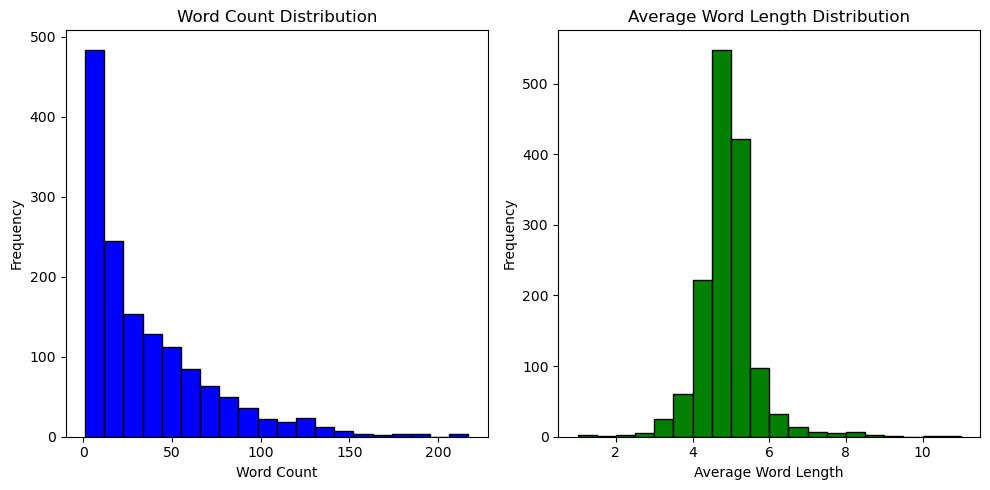

In [141]:
# Visualization
plt.figure(figsize=(10, 5))

# Plot word count
plt.subplot(1, 2, 1)
plt.hist(features['word count'], bins=20, color='blue', edgecolor='black')
plt.title('Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

# Plot average word length
plt.subplot(1, 2, 2)
plt.hist(features['avg word length'], bins=20, color='green', edgecolor='black')
plt.title('Average Word Length Distribution')
plt.xlabel('Average Word Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


![Before Cleaning POS](before_cleaning_pos.png)
----
Before cleaning the transcripts

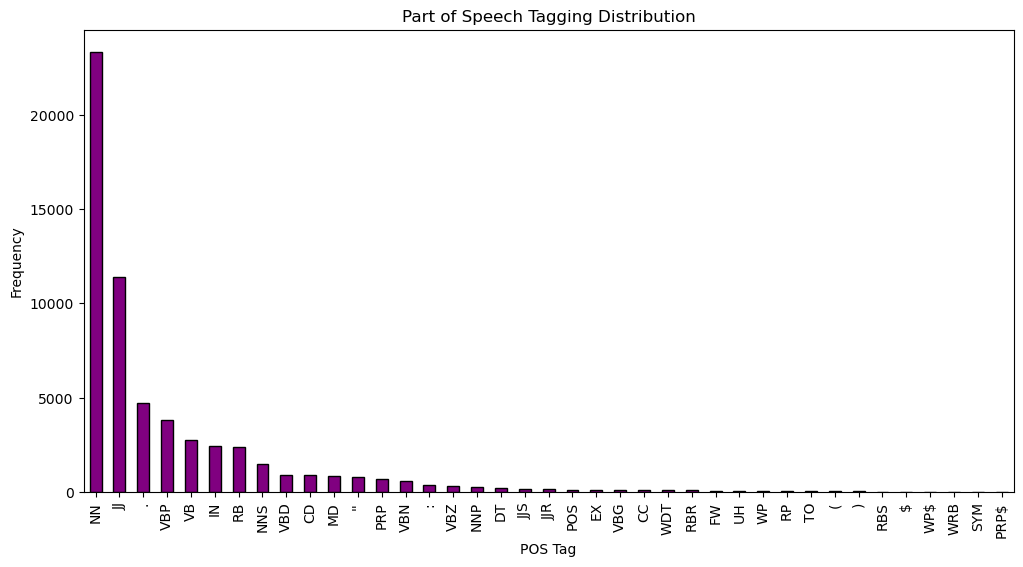

In [143]:
# Visualization of POS tagging
pos_counts = features['pos tagging'].apply(lambda x: [tag for word, tag in x]).explode().value_counts()
plt.figure(figsize=(12, 6))
pos_counts.plot(kind='bar', color='purple', edgecolor='black')
plt.title('Part of Speech Tagging Distribution')
plt.xlabel('POS Tag')
plt.ylabel('Frequency')
plt.show()

Semantic Features

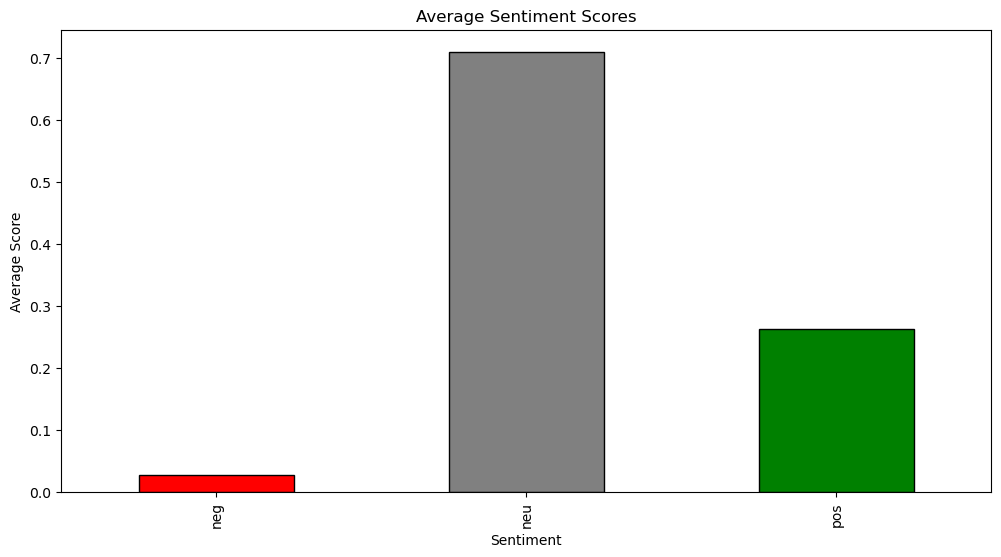

In [144]:
# Sentiment Analysis with Vader
analyzer = SentimentIntensityAnalyzer()
features['sentiment'] = merged_df['processed_answers'].apply(lambda x: analyzer.polarity_scores(x))
features['sentiment'].head()

# Visualization of Sentiment Analysis
sentiment_df = pd.DataFrame(features['sentiment'].tolist())
plt.figure(figsize=(12, 6))
sentiment_df[['neg', 'neu', 'pos']].mean().plot(kind='bar', color=['red', 'grey', 'green'], edgecolor='black')
plt.title('Average Sentiment Scores')
plt.xlabel('Sentiment')
plt.ylabel('Average Score')
plt.show()

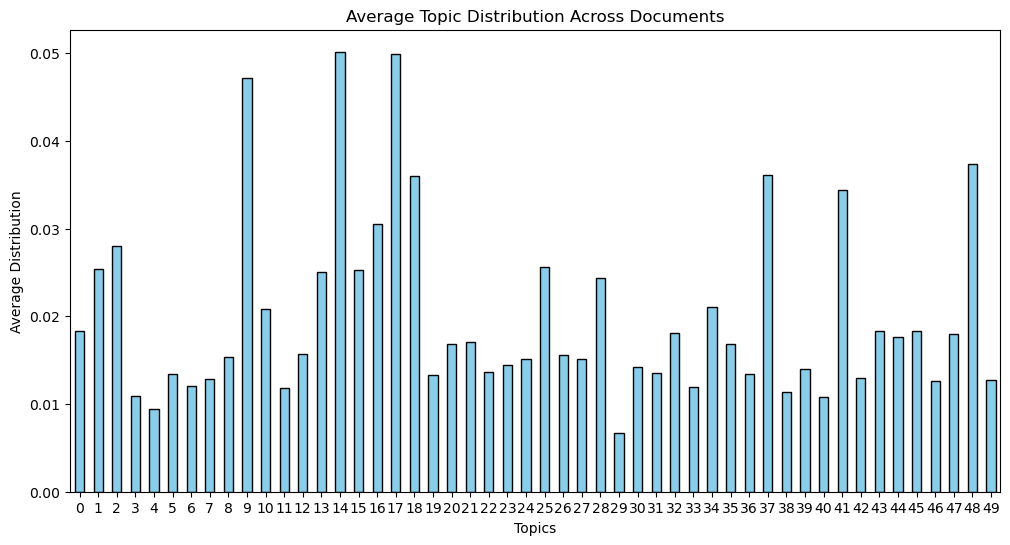

Topic 0:  ['know', 'medic', 'like', 'field', 'um', 'school', 'hope', 'research', 'uh', 'talk', 'come', 'student', 'yep', 'junior', 'physic', 'basic', 'decid', 'mit', 'yeah', 'sort']
Topic 1:  ['work', 'uh', 'um', 'team', 'like', 'know', 'tri', 'basic', 'sort', 'time', 'anoth', 'person', 'peopl', 'realli', 'make', 'actual', 'end', 'problem', 'way', 'okay']
Topic 2:  ['um', 'like', 'work', 'know', 'tri', 'realli', 'project', 'team', 'lot', 'guess', 'time', 'sort', 'lab', 'uh', 'thing', 'group', 'event', 'abl', 'student', 'direct']
Topic 3:  ['like', 'um', 'feel', 'come', 'chair', 'environment', 'work', 'time', 'effort', 'room', 'lot', 'dorm', 'let', 'know', 'say', 'group', 'dine', 'make', 'plan', 'idea']
Topic 4:  ['product', 'um', 'busi', 'work', 'design', 'exampl', 'things', 'moment', 'time', 'ok', 'like', 'happen', 'deadlin', 'recogn', 'comput', 'becom', 'uh', 'manag', 'internship', 'tech']
Topic 5:  ['okay', 'think', 'work', 'uh', 'past', 'experi', 'look', 'internship', 'peopl', 'rea

In [162]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

# Create a CountVectorizer to convert the text data into a matrix of token counts
vectorizer = CountVectorizer(stop_words='english')
doc_term_matrix = vectorizer.fit_transform(merged_df['processed_answers'])
# Create an LDA model
lda = LatentDirichletAllocation(n_components=50, random_state=42)  # You can adjust the number of topics
lda.fit(doc_term_matrix)
# Get the topic distribution for each document
topic_distribution = lda.transform(doc_term_matrix)
# Create a DataFrame to hold the topic distribution
topic_distribution_df = pd.DataFrame(topic_distribution, columns=[f'{i}' for i in range(lda.n_components)])
# Display the topic distribution
topic_distribution_df.head()

# Visualization of Topic Distribution
plt.figure(figsize=(12, 6))
topic_distribution_df.mean().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Topic Distribution Across Documents')
plt.xlabel('Topics')
plt.ylabel('Average Distribution')
plt.xticks(rotation=0)
plt.show()

# Specify the meaning of each topic
topic_words = lda.components_
feature_names = vectorizer.get_feature_names_out()

# Extract the top 20 features for each topic
top_n = 20
for index, topic in enumerate(topic_words):
    top_features_ind = topic.argsort()[-top_n:][::-1]
    print(f"Topic {index}: ", [feature_names[i] for i in top_features_ind])


Advanced Features

In [167]:
# Word embeddings with BERT (Hugging Face)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [204]:
import torch
import numpy as np
from tqdm import tqdm  # Import tqdm for progress bar

# Tokenize the text
def get_bert_embeddings(sentences):
    embeddings = []
    
    # Use tqdm to show progress
    for sentence in tqdm(sentences, desc="Processing sentences"):
        # Tokenize and get input Id and attention mask
        inputs = tokenizer(sentence, return_tensors="pt", padding="max_length", truncation=True, max_length=26)
        
        # Move inputs to CUDA device
        inputs = {key: value.to('cuda') for key, value in inputs.items()}
        
        # Use BERT
        with torch.no_grad():
            outputs = model(**inputs)
        
        # Pool output
        cls_embedding = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()  # Move to CPU before converting to numpy
        embeddings.append(cls_embedding)

    # Return an array of embeddings
    return np.array(embeddings)

# Ensure the model is on the same device (CUDA)
model.to('cuda')

# Get embeddings and ensure they match the length of the index
word_embeddings = get_bert_embeddings(merged_df['processed_answers'])
if word_embeddings.shape[0] != len(merged_df):
    raise ValueError(f"Length of embeddings ({word_embeddings.shape[0]}) does not match length of index ({len(merged_df)})")

# Reshape the embeddings to be 1D for each document
features['word embeddings'] = word_embeddings.tolist()  # Convert to list to avoid shape issues

# Get interpretable features for each word using BERT embeddings
def get_interpretable_features(embeddings):
    interpretable_features = []
    for embedding in embeddings:
        # Here you can define how to interpret the embeddings, e.g., using clustering or dimensionality reduction
        interpretable_features.append(embedding)  # Placeholder for actual interpretation logic
    return interpretable_features

# Add interpretable features to the features DataFrame
features['interpretable features'] = get_interpretable_features(features['word embeddings'])


Processing sentences: 100%|██████████| 1457/1457 [00:25<00:00, 57.50it/s]


In [205]:
embedded_words = features['word embeddings']  # Directly use the list of embeddings
embedded_words2 = features['interpretable features']  # Directly use the list of embeddings

print(embedded_words[:5])  # Print the first 5 embedded words
print(embedded_words2[:5])  # Print the first 5 embedded words

0    [-0.11673397570848465, -0.10921718925237656, 0...
1    [0.08012373745441437, 0.28656598925590515, 0.6...
2    [-0.013793849386274815, 0.13234229385852814, 0...
3    [-0.0749645009636879, 0.15353424847126007, 0.4...
4    [-0.5609394907951355, -0.281798779964447, 0.51...
Name: word embeddings, dtype: object
0    [-0.11673397570848465, -0.10921718925237656, 0...
1    [0.08012373745441437, 0.28656598925590515, 0.6...
2    [-0.013793849386274815, 0.13234229385852814, 0...
3    [-0.0749645009636879, 0.15353424847126007, 0.4...
4    [-0.5609394907951355, -0.281798779964447, 0.51...
Name: interpretable features, dtype: object


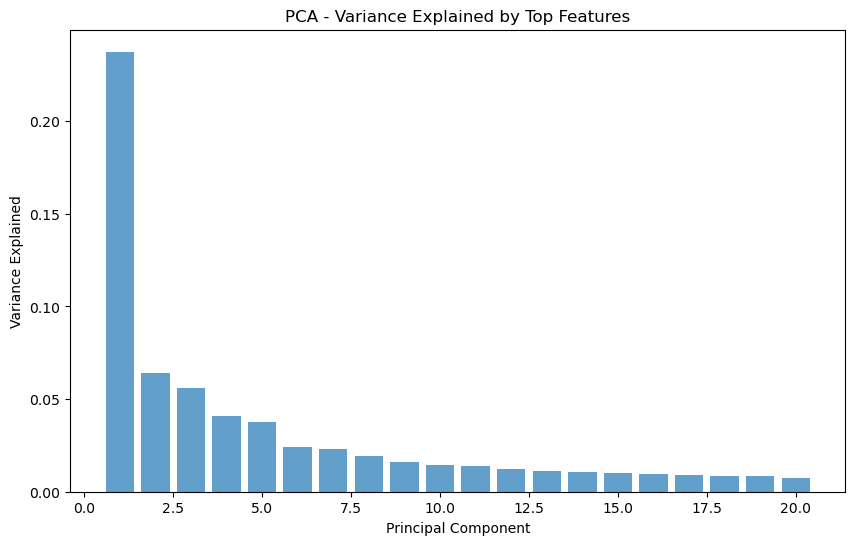

0    [2.6488188601112177, -1.8406984536140294, -0.5...
1    [-0.9882129648321624, 1.3036392194903115, 0.60...
2    [-2.417912856420553, -2.2990021810815886, -1.1...
3    [-1.292696370995932, 1.1702512670088314, 0.226...
4    [-1.8769280963272439, 1.679912311832971, 0.388...
Name: pca word embeddings, dtype: object

In [206]:
from sklearn.decomposition import PCA

# Perform PCA to find top features
def perform_pca(embeddings, n_components=20):
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(embeddings)
    return principal_components, pca.explained_variance_ratio_
# Prepare embeddings for PCA
all_embeddings = np.vstack(features['word embeddings'].values)
# Apply PCA on the word embeddings
pca_components, explained_variance = perform_pca(all_embeddings)

# Visualize the top features
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('PCA - Variance Explained by Top Features')
plt.show()

features['pca word embeddings'] = list(pca_components)
features['pca word embeddings'].head()

In [199]:
from gensim.models import Word2Vec

# Tokenize the processed answers
tokenized_answers = [answer.split() for answer in merged_df['processed_answers']]

# Train a skip-gram model
skip_gram_model = Word2Vec(sentences=tokenized_answers, vector_size=100, window=5, min_count=1, sg=1)

# Create a function to get interpretable features for each word
def get_skip_gram_interpretable_features(words):
    embeddings = []
    for word in words:
        if word in skip_gram_model.wv:
            # Get the embedding and its corresponding word
            embedding = skip_gram_model.wv[word]
            embeddings.append((word, embedding))
    return embeddings

# Generate interpretable features for the processed answers
features['skip-gram interpretable features'] = merged_df['processed_answers'].apply(lambda x: get_skip_gram_interpretable_features(x.split()))
embedded_words = features['skip-gram interpretable features']  # Directly use the list of embeddings
print(embedded_words[:5]) 


0    [(im, [-0.21964093, 0.10537602, 0.12219932, -0...
1    [(ok, [-0.22570555, 0.098539986, 0.10616588, -...
2    [(ah, [-0.20575055, 0.1300181, 0.1165342, -0.0...
3    [(ok, [-0.22570555, 0.098539986, 0.10616588, -...
4    [(ahh, [-0.117476515, 0.07227571, 0.082493745,...
Name: skip-gram interpretable features, dtype: object


In [196]:
from gensim.models import FastText

# Tokenize the processed answers
tokenized_answers_fasttext = [answer.split() for answer in merged_df['processed_answers']]

# Train a FastText model
fasttext_model = FastText(sentences=tokenized_answers_fasttext, vector_size=100, window=5, min_count=1, sg=1)

# Create a function to get interpretable features for each word
def get_fasttext_interpretable_features(words):
    embeddings = []
    for word in words:
        if word in fasttext_model.wv:
            # Get the embedding and its corresponding word
            embedding = fasttext_model.wv[word]
            embeddings.append((word, embedding))
    return embeddings

# Generate interpretable features for the processed answers
features['fasttext interpretable features'] = merged_df['processed_answers'].apply(lambda x: get_fasttext_interpretable_features(x.split()))
interpretable_features = features['fasttext interpretable features']  # Directly use the list of interpretable features
print(interpretable_features[:5]) 

0    [(im, [-0.2644923, 0.124577895, 0.047895383, 0...
1    [(ok, [-0.17872341, 0.113645524, 0.0051109456,...
2    [(ah, [-0.21114463, 0.10069586, 0.034661345, 0...
3    [(ok, [-0.17872341, 0.113645524, 0.0051109456,...
4    [(ahh, [-0.16146676, 0.062809296, 0.03324235, ...
Name: fasttext interpretable features, dtype: object


In [ ]:
# Create the merged df for directly for later use
merged_df = structured_df.merge(scores_df[['Participant', 'Overall', 'Excited']], on='Participant', how='left')
# Save to a new CSV file
merged_df.to_csv('data/clean_transcripts.csv', index=False)  

In [209]:
import scipy.stats as stats

def find_top_words(number):
    overall_accumulator = []
    excited_accumulator = []
    for word in word_count.columns:
        corr, _ = stats.pearsonr(word_count[word], scores_data["Overall"])
        overall_accumulator.append({"Word": word, "Correlation": corr})
        corr, _ = stats.pearsonr(word_count[word], scores_data["Excited"])
        excited_accumulator.append({"Word": word, "Correlation": corr})

    overall_corr = pd.DataFrame(overall_accumulator)
    excited_corr = pd.DataFrame(excited_accumulator)

    overall_corr["Abs Correlation"] = overall_corr["Correlation"].abs()
    excited_corr["Abs Correlation"] = excited_corr["Correlation"].abs()

    top_10_overall = overall_corr.nlargest(number, 'Abs Correlation')
    top_10_excited = excited_corr.nlargest(number, 'Abs Correlation')

    return [top_10_overall, top_10_excited]

# Using correlation to compare: word count, average word length, word frequency, and sentiment analysis
feature_cols = ["word count", "avg word length"]
outcome_cols = ["Overall", "Excited"]

Overall_correlation = []
Excited_correlation = []

for feature in feature_cols:
  corr, _ = stats.pearsonr(features[feature], scores_df["Overall"])
  Overall_correlation.append({"Feature": feature, "Correlation": corr})
  corr, _ = stats.pearsonr(features[feature], scores_df["Excited"])
  Excited_correlation.append({"Feature": feature, "Correlation": corr})

# Find correlation for the most impactful words from the word_count CountVectorizer
top_overall, top_excited = find_top_words(20)

for _, row in top_overall.iterrows():
  Overall_correlation.append({"Feature": f"word - {row['Word']}", "Correlation": row['Correlation']})

for _, row in top_excited.iterrows():
  Excited_correlation.append({"Feature": f"word - {row['Word']}", "Correlation": row['Correlation']})

# Find correlation for the sentiment analysis
# Expand sentiment column into its own dictionary
sentiment_df = features["sentiment"].apply(pd.Series)
for feature in ['neg', 'neu', 'pos', 'compound']:
  corr, _ = stats.pearsonr(sentiment_df[feature], scores_df["Overall"])
  Overall_correlation.append({"Feature": f"sentiment - {feature}", "Correlation": corr})
  corr, _ = stats.pearsonr(sentiment_df[feature], scores_df["Excited"])
  Excited_correlation.append({"Feature": f"sentiment - {feature}", "Correlation": corr})

ValueError: x and y must have the same length.

In [208]:
print(features.head())

   word count  avg word length  \
0           3         4.333333   
1          60         4.900000   
2          24         4.416667   
3          65         4.815385   
4          16         5.687500   

                                         pos tagging  \
0       [(im, JJ), (pretti, RB), (good, JJ), (., .)]   
1  [(ok, JJ), (uhm, JJ), (look, NN), (resum, NN),...   
2  [(ah, JJ), (interest, NN), (kinda, NN), (laid,...   
3  [(ok, JJ), (uhm, JJ), (one, CD), (thing, NN), ...   
4  [(ahh, JJ), (guess, NN), (easiest, JJS), (team...   

                                           sentiment  \
0  {'neg': 0.0, 'neu': 0.408, 'pos': 0.592, 'comp...   
1  {'neg': 0.061, 'neu': 0.731, 'pos': 0.208, 'co...   
2  {'neg': 0.0, 'neu': 0.585, 'pos': 0.415, 'comp...   
3  {'neg': 0.0, 'neu': 0.893, 'pos': 0.107, 'comp...   
4  {'neg': 0.0, 'neu': 0.843, 'pos': 0.157, 'comp...   

                                     word embeddings  \
0  [-0.11673397570848465, -0.10921718925237656, 0...   
1  [0.080

In [ ]:
import pandas as pd
import numpy as np

# Function to select k best features based on correlation with a target variable
def select_best_features(features_df, target_variable, k):
    # Calculate the correlation matrix
    correlation_matrix = features_df.corr()
    
    # Get the absolute correlation values with the target variable
    target_correlation = correlation_matrix[target_variable].abs()
    
    # Select the top k features based on correlation
    best_features = target_correlation.nlargest(k + 1).index.tolist()  # +1 to include the target variable itself
    best_features.remove(target_variable)  # Remove the target variable from the list
    return best_features

# Assuming 'target_variable' is the name of the target column in your DataFrame
target_variable = 'your_target_variable'  # Replace with your actual target variable name
k = 5  # Specify the number of best features to select

# Convert interpretable features to a DataFrame for correlation analysis
features_df = pd.DataFrame(interpretable_features.tolist(), columns=[f'feature_{i}' for i in range(len(interpretable_features[0]))])

# Select the best features
best_features = select_best_features(features_df, target_variable, k)
print(best_features)

